# Amazon Customer Feedback Enhancement Initiative

## Background:
Amazon, the world's largest online retailer, prides itself on customer-centricity. Customer reviews form the backbone of Amazon's product ecosystem, guiding millions of purchasing decisions daily and playing a pivotal role in vendor and product rankings. As the platform continues to scale, the sheer volume of reviews makes manual monitoring an insurmountable task. 

## Problem Statement:
While positive reviews drive sales, negative reviews, if not addressed promptly, can harm brand reputation, reduce customer trust, and lead to potential revenue losses. Given the vast number of reviews generated daily, Amazon faces the challenge of **efficiently identifying and addressing negative reviews in real-time**.

## Objective:
Develop an automated solution using machine learning and natural language processing techniques to:
1. Accurately identify negative reviews among the millions of reviews posted on Amazon daily.
2. Categorize the severity of the negative feedback to prioritize actions.
3. Extract actionable insights from negative reviews to provide to vendors, helping them improve product quality and customer experience.
   
## Value Proposition:
By effectively identifying and addressing negative reviews, Amazon aims to:
1. Enhance customer trust by showing responsiveness to feedback.
2. Increase customer retention by resolving issues proactively.
3. Boost overall platform sales by improving product and vendor quality through actionable feedback.
4. Potentially save millions in revenue by preventing customer churn and fostering brand loyalty.

## Measure of Success:
A successful solution will showcase a significant improvement in the **Recall metric**, ensuring that the vast majority of negative reviews are captured. The financial implications of improved customer retention and vendor product enhancement will serve as a testament to the initiative's success.


# 1.0 Imports

In [4]:
import pandas                            as pd
import string
import re
import numpy                             as np

import seaborn                           as sns
import matplotlib.pyplot                 as plt
import numpy                             as np

import nltk
from nltk.stem                          import WordNetLemmatizer
from nltk.corpus                        import stopwords, wordnet

from sklearn.model_selection            import train_test_split
from sklearn.metrics                    import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from wordcloud                          import WordCloud

from keras.preprocessing.text           import Tokenizer
from keras.preprocessing.sequence       import pad_sequences
import tensorflow                       as tf

sns.set_style('darkgrid')

2023-09-25 09:10:31.033177: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 09:10:31.060849: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 09:10:31.062232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 09:10:31.756701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1.1 Load Data

In [15]:
PATH = '/home/edilson07/projects/llm_gen/datasets/'

df_raw = pd.read_csv(PATH + 'train.csv', header=None)
df_raw.columns = ['sentiment','title','text']

In [16]:
df_raw.head()

,sentiment,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [17]:
df_raw.shape

(3600000, 3)

## 1.2 Helper Funtions

In [18]:
# Lemmatize Words
def lemmatize_word(word):
    lemma = lemmatizer.lemmatize(word, pos=wordnet.VERB)
    return lemmatizer.lemmatize(lemma, pos=wordnet.NOUN)

# Process Function
def process_text(text):
    #convert do uncased
    text = text.lower()
    
    # Remove Pontuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokemnization, lemmatization and stopwords removal
    words = text.split()
    filtered_and_lemmatized_words = [lemmatize_word(word) for word in words if word.lower() not in english_stopwords]
    text = ' '.join(filtered_and_lemmatized_words)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'black',
        max_words = 350,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

def evaluate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

def sample_prediction(model, tokenizer, validation_data, original_data, num_samples=5, threshold=0.5):
    # Seleciona uma amostra aleatória dos dados de validação
    sample_indices = np.random.choice(validation_data.index, size=num_samples, replace=False)
    
    # Obter os textos processados e originais usando os índices selecionados
    sample_texts_processed = validation_data.loc[sample_indices, 'text'].tolist()
    sample_texts_original = original_data.loc[sample_indices, 'text'].tolist()
    
    sample_true_sentiments = validation_data.loc[sample_indices, 'sentiment'].tolist()
    
    # Tokeniza e padroniza o texto processado da amostra
    sequences = tokenizer.texts_to_sequences(sample_texts_processed)
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Faz previsões
    predictions = model.predict(data)
    predicted_sentiments = [1 if pred[0] > threshold else 0 for pred in predictions]
    
    # Exibe os resultados usando os textos originais
    for text, true_sent, pred_sent in zip(sample_texts_original, sample_true_sentiments, predicted_sentiments):
        print('-' * 100)
        print(f"Original Text: {text}")
        print(f"Original Sentiment: {true_sent}")
        print(f"Predicted Sentiment: {pred_sent}")
    print('-' * 100)

# 2.0 Data Descrition

The full dataset contains 3.6 million reviews. However, due to computational constraints, I will be working with a subset of 90,000 examples, which represents 2.5% of the entire dataset.

## 2.1 Sample Data

In [19]:
df_raw, _ = train_test_split(df_raw, test_size=0.975, stratify=df_raw['sentiment'], random_state=42)
df_raw = df_raw.reset_index(drop=True)
df_raw.shape

(90000, 3)

## 2.2 Rename Columns

In [20]:
df_desc = df_raw.copy()

I won't need the title column

In [21]:
df_desc = df_desc.drop(['title'], axis=1)

Transform sentiment to Categorical

In [22]:
df_desc['sentiment'] = df_desc['sentiment'].apply(lambda x: 'Negative' if x == 1 else 'Positive')

## 2.3 Check NaNs

In [23]:
df_desc.isna().sum()

sentiment    0
text         0
dtype: int64

## 2.4 Data Types

In [24]:
df_desc.dtypes

sentiment    object
text         object
dtype: object

# 3.0 Inspect Data

## 3.1 Check Class Balance

In [25]:
df_eda = df_desc.copy()

In [26]:
df_eda['sentiment'].value_counts(normalize=True)

sentiment
Positive    0.5
Negative    0.5
Name: proportion, dtype: float64

The target is balanced.

## 3.2 Inspect Reviews

Let's take a if we have extreme large reviews

In [27]:
#Size of the text
df_eda['text_lenght'] = df_eda['text'].apply(lambda x: len(str(x).split()))
df_eda['text_lenght'].sort_values(ascending=False)

88289    216
67922    210
74980    209
18615    208
88692    207
        ... 
82750      7
63595      6
9253       5
53474      3
42659      1
Name: text_lenght, Length: 90000, dtype: int64

In [28]:
df_eda.query('text_lenght == 216')['text'].iloc[0]

"I have been trying to use this Shaver for a month now, and it still will not shave my neck, and I have to go over my face slowly about 4 time before it starts it even feel like I might be getting a close shave. I have tried it in the shower wet and before or after the shower, it still don't work. Oh but it sounds like it does! In the shower with a little gel on my face, this thing sound like it cutting every hair I have, but when I rinse off my face, I see that it didn't shave as well as I would like and that I'm still going to have to go back over my neck with a razor. If I was a 60 year old man, this would be OK. But no, I'm 27 trying to make a like for my self, and if my boss saw I can't even shave right, what's he going to think?The battery life is good, last about a week with one 5 minutes each day. The cleaner / charger is really loud so the only time I can use it is when I'm not home. For a $140 shaver, I was expecting a lot more. Save your money and try something else."

That's a long review but I will consider to be extremely long until 512 words. So no need to filter anything here.

## 3.3 Most Used Words

We will look now which words appears the most on the dataset.

In [29]:
from collections import Counter

#concatenate all texts in one variable
all_texts = ''.join(df_eda['text'])

#Take words
words = all_texts.split()

#Count Words
word_counts = Counter(words)
df_words = pd.DataFrame(word_counts.items(), columns=['word','count'])

In [30]:
df_words.sort_values(by='count', ascending=False).head(20)

,word,count
15,the,293319
22,and,178579
39,to,163666
36,a,160514
71,I,142202
33,of,132006
20,is,115505
149,it,92125
56,this,90573
3,in,74073


As we can see there are a lot of 'stopwords', words that don't carry any meaning, we need to remove them. The next section we will make some text processing for this kind of problems.

# Text Preprocessing

### Stemming/ Lematization
For grammatical reasons, documents are going to use different forms of a word, such as *write, writing and writes.* Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes. 

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word
![Stemming and Lematization](https://qph.fs.quoracdn.net/main-qimg-cd7f4bafaa42639deb999b1580bea69f)


### Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are...

![Stopwords English](https://4.bp.blogspot.com/-yiEr-jCVv38/Wmk10d84DYI/AAAAAAAAk0o/IfgjfjpgrxM5NosUQrGw7PtLvgr6DAG8ACLcBGAs/s1600/Screen%2BShot%2B2018-01-24%2Bat%2B5.41.21%2BPM.png)

I will use **NLTK** Python library to make this text processing

In [31]:
# Download necessary resources for nltk
nltk.download('wordnet')
nltk.download('stopwords')

# Inicialize Lemmatizer and set Stopwords in english
lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))

df_eda['text'] = df_eda['text'].apply(process_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/edilson07/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/edilson07/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's see how our most used words ended with now

In [32]:
#concatenate all texts in one variable
all_texts_filtered = ''.join(df_eda['text'])

#Take words
words_filtered = all_texts_filtered.split()

#Count Words
word_counts_filtered = Counter(words_filtered)
df_words_filtered = pd.DataFrame(word_counts_filtered.items(), columns=['word','count'])

In [33]:
top_20_words = df_words_filtered.sort_values(by='count', ascending=False).head(20)

/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


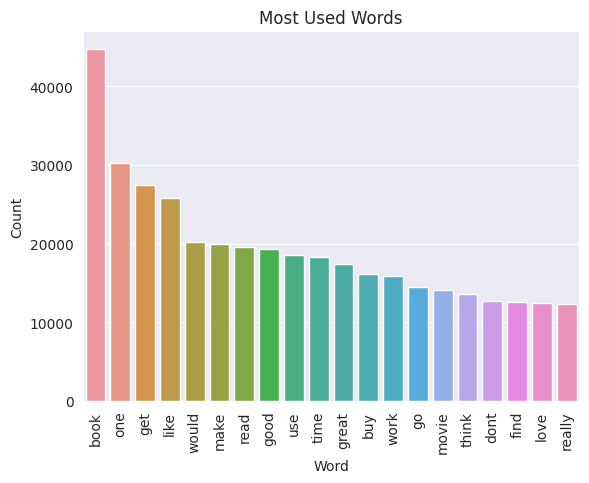

In [34]:
sns.barplot(top_20_words, x='word', y='count')
plt.xticks(rotation=90);
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Used Words');


Notice that 'book' is most used word, because the majority of sales in amazon are from books. But there are some words that capture the sentiment that are used a lot, like: 'good', 'great', 'love'.

### Positive Words

Let's make some Word Cloud to see more visual the most used words. First, looking at POSITIVE reviews

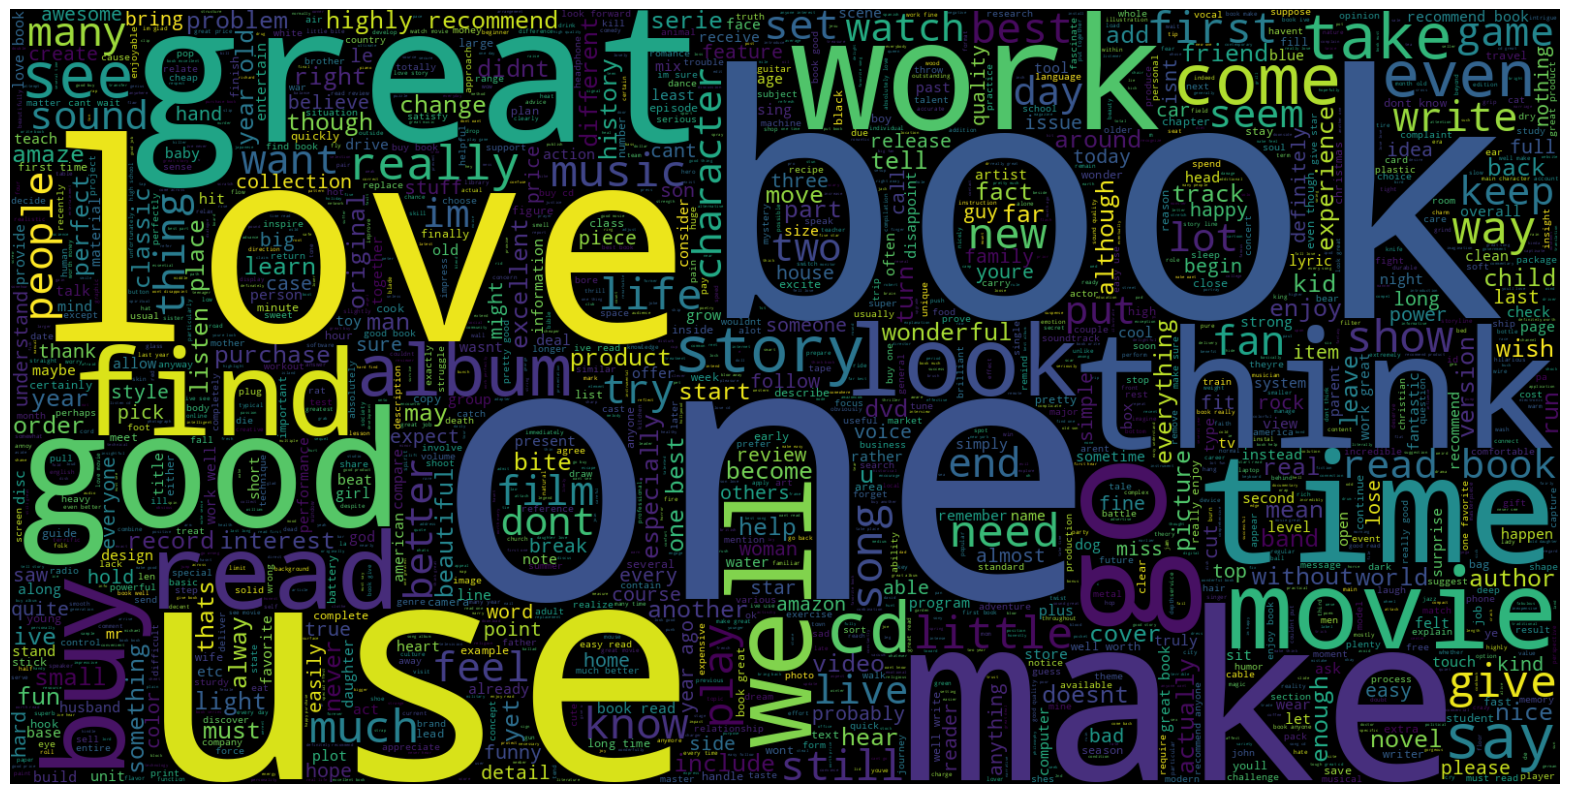

In [35]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_eda[df_eda.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")  # Desativar os eixos
plt.gca().set_frame_on(False)  # Remover a borda
plt.show()

### Negative Words

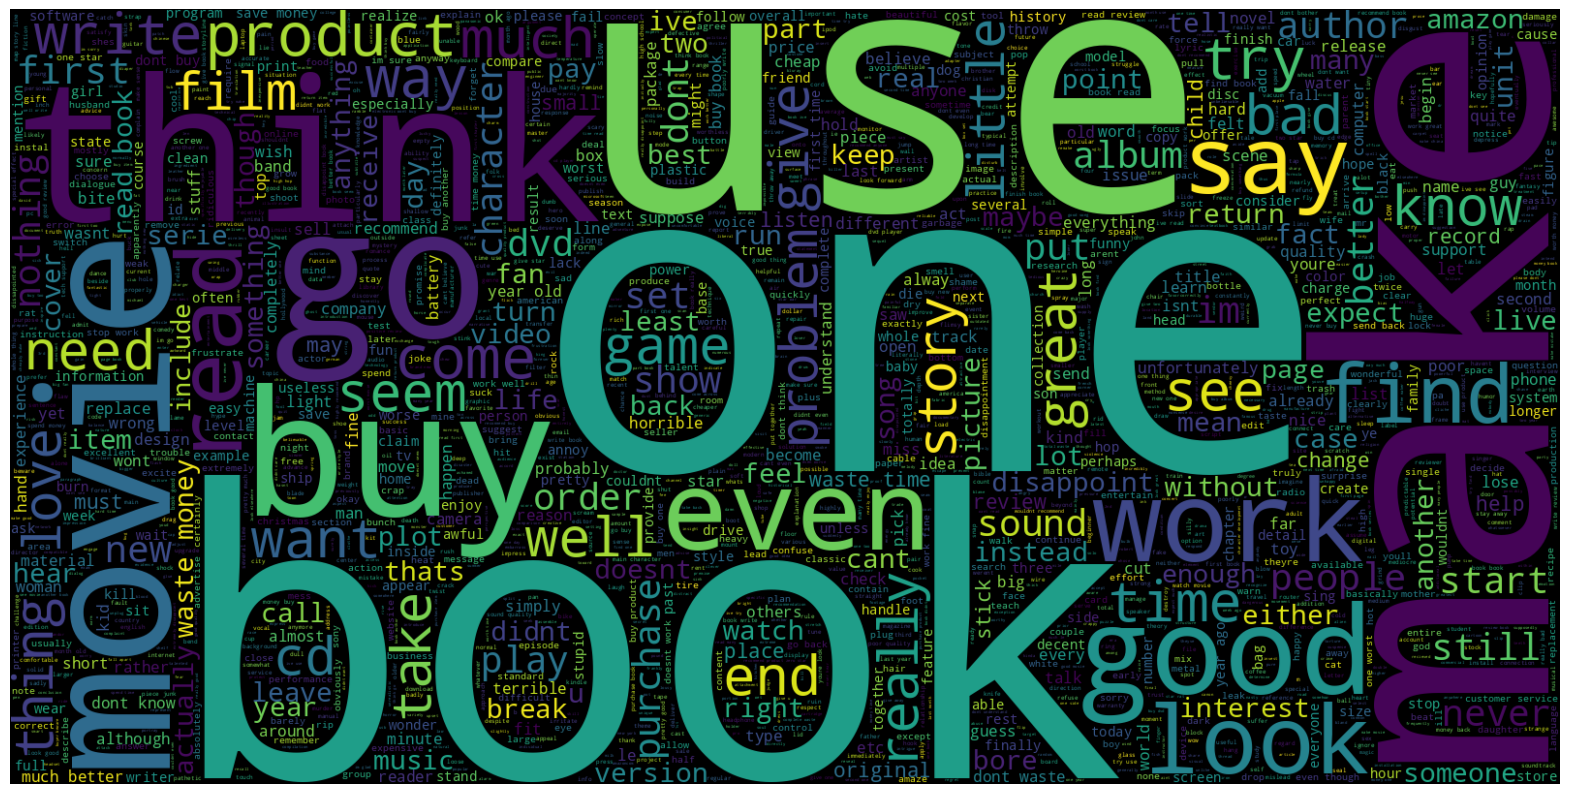

In [36]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_eda[df_eda.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")  # Desativar os eixos
plt.gca().set_frame_on(False)  # Remover a borda
plt.show()

We have some negative words that appears here, like 'disappoint', 'bad', 'never', 'waste time'. The algorithm will probably seek for these words in order to classify the sentiment.

# 4.0 Prepare Data

Now let's prepare our data to train our Machine Learning Model.

In [37]:
df_prep = df_eda.copy()
df_prep = df_prep.loc[:,['sentiment','text']]

In [38]:
sentiment_map = {
    'Positive':1,
    'Negative':0
}

df_prep['sentiment'] = df_prep['sentiment'].map(sentiment_map)

## 4.1 Split Train-Validation

In [39]:
train, validation = train_test_split(df_prep, test_size=0.3, random_state=42, stratify=df_prep['sentiment'])

## 4.2 Tokenization

# Tokenization
Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called *tokens* , perhaps at the same time throwing away certain characters, such as punctuation. The process is called **Tokenization.**
![Tokenization](https://miro.medium.com/v2/resize:fit:720/format:webp/1*PZYP2nL6Zc_jpkaHLRxLQQ.png)

`tokenizer` create tokens for every word in the data corpus and map them to a index using dictionary.

`MAX_NUM_WORDS` represents the total number of word in the vocabulary of our model, that means it will search for the 10.000 most used words and 'remember' them as tokens. 

In [40]:
# Define Vocabulary
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 512

#Define Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

#Train Tokenizer
tokenizer.fit_on_texts(train['text'])

#Transform the tokens in sequence
sequences_train = tokenizer.texts_to_sequences(train['text'])
sequences_validation = tokenizer.texts_to_sequences(validation['text'])

#Each sequence need to be the same size, padding complete them with zeros.
X_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
X_validation = pad_sequences(sequences_validation, maxlen=MAX_SEQUENCE_LENGTH)

In [41]:
y_train = train['sentiment'].copy()
y_validation = validation['sentiment'].copy()

In [42]:
word_index = tokenizer.word_index

## 4.2 Word Embedding

Word Embeddings are dense representations of the individual words in a text, taking into account the context and other surrounding words that that individual word occurs with.

The dimensions of this real-valued vector can be chosen and the semantic relationships between words are captured more effectively than a simple Bag-of-Words Model.

![Word Embedding](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*SYiW1MUZul1NvL1kc1RxwQ.png)

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use **Transfer Learning**. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding lik**e GloVe & Word2V**ec gives more insights for a word which can be used for classificatiok.In this notebook, I use **GloVe Embedding from Stanford AI** which can be found [here](https://nlp.stanford.edu/projects/glove/)here

In [111]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
# GLOVE_PATH = '/home/edilson07/projects/llm_gen/glove.6B.zip'
# import zipfile

# with zipfile.ZipFile(GLOVE_PATH, 'r') as zip_ref:
#     zip_ref.extractall('/home/edilson07/projects/llm_gen/')

In [43]:
GLOVE_EMB = '/home/edilson07/projects/llm_gen/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../best_model.hdf5'

In [44]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [45]:
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:  # Se o índice é maior ou igual a MAX_NUM_WORDS, continue para a próxima iteração
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Resulting Embedding Layer

In [46]:
embedding_layer = tf.keras.layers.Embedding(MAX_NUM_WORDS,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# 5.0 Model Architecture and Training - LSTM

# Sequential Model in Deep Learning

In Deep Learning, the `Sequential` model is a linear approach to stacking layers, thereby constructing a machine learning model. It allows you to build models layer by layer, where each layer has weights corresponding to the following layer.

### Sequence Model
![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

## Breakdown of the Provided Model Architecture

The provided architecture is a Keras functional model, which allows for more flexibility as compared to the `Sequential` model. Let's detail each part:

### Input Layer

- **Input Layer**: This is the entry layer that receives the data. The shape defines the sequence length, which in this case is `MAX_SEQUENCE_LENGTH`.

### Embedding Layer

- **Embedding Layer**: Here we are using the embedding layer create before.

### Spatial Dropout

- **SpatialDropout1D**: Similar to regular Dropout, `SpatialDropout1D` deactivates (zeroes out) entire dimensions of the embedding. This helps make the model less sensitive to specific noise in embedding dimensions.

### Convolution Layer

- **Conv1D**: A one-dimensional convolutional layer. It slides filters over the input sequence to detect local patterns (like bigrams or trigrams). Here, it's using 64 filters and a kernel size of 5.

### Bi-directional LSTM

- **Bidirectional LSTM**: This is an LSTM layer that processes the input in two ways: one from start to end and another from end to start. This helps capture long-range patterns and dependencies in the text.

### Dense Layers

- **Dense Layers**: Fully connected layers. The `Dense` layer is a standard neural layer. Here, we have two such layers with 512 neurons each. In between them, we have a `Dropout` layer to prevent overfitting.

### Output Layer

- **Output Layer**: The final layer that provides the output. In this case, we have 1 neuron, corresponding to one of the 2 classes. The 'sigmoid' activation ensures the output is binary.

Finally, the model is compiled using the 'adam' optimizer and the 'binary_crossentropy' loss function, which is suitable for binary classification problems.

In [113]:
from tensorflow.keras.layers import Input, SpatialDropout1D, Conv1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

# Input
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_layer')

# Embedding
embedded_sequences = embedding_layer(input_layer)

#Spatial Dropout similar to regular Dropout but for embeddings(spaces)
spatial_dropout = SpatialDropout1D(0.2, name='spatial_dropout')(embedded_sequences)

# Convolution
conv1 = Conv1D(64, 5, activation='relu', name='conv1')(spatial_dropout)

# Bi-directional LSTM
bi_lstm = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2), name='bi_lstm')(conv1)

# Dense layers
dense1 = Dense(512, activation='relu', name='dense1')(bi_lstm)
dropout = Dropout(0.5, name='dropout')(dense1)
dense2 = Dense(512, activation='relu', name='dense2')(dropout)

# Output
output_layer = Dense(1, activation='sigmoid', name='output_layer')(dense2)

# Compile model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 300)          3000000   
                                                                 
 spatial_dropout (SpatialDr  (None, 512, 300)          0         
 opout1D)                                                        
                                                                 
 conv1 (Conv1D)              (None, 508, 64)           96064     
                                                                 
 bi_lstm (Bidirectional)     (None, 128)               66048     
                                                                 
 dense1 (Dense)              (None, 512)               66048     
                                                           

## 5.1 Training Model

In [118]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [50]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

Epoch 1/50


2023-09-24 10:01:09.762246: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 129024000 exceeds 10% of free system memory.


1969/1969 [==============================] - 928s 469ms/step - loss: 0.4732 - accuracy: 0.7714 - val_loss: 0.4099 - val_accuracy: 0.8085
Epoch 2/50
1969/1969 [==============================] - 927s 471ms/step - loss: 0.3902 - accuracy: 0.8243 - val_loss: 0.3818 - val_accuracy: 0.8290
Epoch 3/50
1969/1969 [==============================] - 940s 478ms/step - loss: 0.3586 - accuracy: 0.8409 - val_loss: 0.3616 - val_accuracy: 0.8358
Epoch 4/50
1969/1969 [==============================] - 959s 487ms/step - loss: 0.3344 - accuracy: 0.8525 - val_loss: 0.3619 - val_accuracy: 0.8396
Epoch 5/50
1969/1969 [==============================] - 927s 471ms/step - loss: 0.3171 - accuracy: 0.8637 - val_loss: 0.3539 - val_accuracy: 0.8414
Epoch 6/50
1969/1969 [==============================] - 921s 468ms/step - loss: 0.2980 - accuracy: 0.8730 - val_loss: 0.3888 - val_accuracy: 0.8397
Epoch 7/50
1969/1969 [==============================] - 908s 461ms/step - loss: 0.2827 - accuracy: 0.8801 - val_loss: 0.376

In [119]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

2023-09-24 17:59:30.710184: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 129024000 exceeds 10% of free system memory.


Epoch 1/50
1969/1969 [==============================] - 958s 483ms/step - loss: 0.4680 - accuracy: 0.7800 - val_loss: 0.3919 - val_accuracy: 0.8186
Epoch 2/50
1969/1969 [==============================] - 986s 501ms/step - loss: 0.3893 - accuracy: 0.8268 - val_loss: 0.3613 - val_accuracy: 0.8386
Epoch 3/50
1969/1969 [==============================] - 963s 489ms/step - loss: 0.3564 - accuracy: 0.8430 - val_loss: 0.3596 - val_accuracy: 0.8370
Epoch 4/50
1969/1969 [==============================] - 986s 501ms/step - loss: 0.3301 - accuracy: 0.8575 - val_loss: 0.3480 - val_accuracy: 0.8454
Epoch 5/50
1969/1969 [==============================] - 963s 489ms/step - loss: 0.3082 - accuracy: 0.8674 - val_loss: 0.3773 - val_accuracy: 0.8458
Epoch 6/50
1969/1969 [==============================] - 917s 466ms/step - loss: 0.2861 - accuracy: 0.8784 - val_loss: 0.3744 - val_accuracy: 0.8435
Epoch 7/50
1969/1969 [==============================] - 957s 486ms/step - loss: 0.2734 - accuracy: 0.8846 - val_

In [120]:
#model.save('lstm_binary_model.h5')

/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
from keras.models import load_model
model = load_model('lstm_binary_model.h5')

2023-09-25 06:45:12.233644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 06:45:12.234245: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 5.2 Analyze sentiments

Let's see how our model classify some of the texts:

In [4]:
sentiment_dict = {
    'Negative': 0,
    'Positive': 1
}

sentiment_map_reverse = {v: k for k, v in sentiment_dict.items()}


In [94]:
sample_prediction(model, tokenizer, validation, df_desc)

1/1 [==============================] - 0s 186ms/step
----------------------------------------------------------------------------------------------------
Original Text: As one wounded by the Church, I highly recommend this book.Hendricks has honestly told the brutal truth by those wounded by the Church. Fellowship in the Church should be all about grace. It is not. It is based on tithing, conformity, and keeping your mouth shut. Only those with some kind of power- financial, political, and community -lead the church, not those with a deep commitment to Jesus Christ. The leaders should be visionaries to adventure out in the freedom of the Gospel. They are not. Hendricks clearly shows that many people leaving the church are genuine believers who want to let God do great things in their life. The Church is the great Preventer of this happening.Grace happens, and the Church shuold get out of the way and let it happen.
Original Sentiment: 1
Predicted Sentiment: 1
---------------------------

Great! Our model appears to generalize effectively. I'm particularly struck by the second example. Despite the phrase 'excellent book' in the sentence, the review was distinctly negative. Yet, the model astutely recognized this!

## 5.3 Evalute Metrics on Validation

In [53]:
y_pred = model.predict(X_validation)
y_pred_classes = (y_pred > 0.5).astype(int)


In [66]:
evaluate_metrics(y_validation, y_pred_classes)

Accuracy: 0.8454
Precision: 0.8467
Recall: 0.8437
F1 Score: 0.8452


We got a nice score on recall metric. Mearning that we could capture 86% of the negatives reviews even though we gonna classify some of them as positives.

### 5.3.1 Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

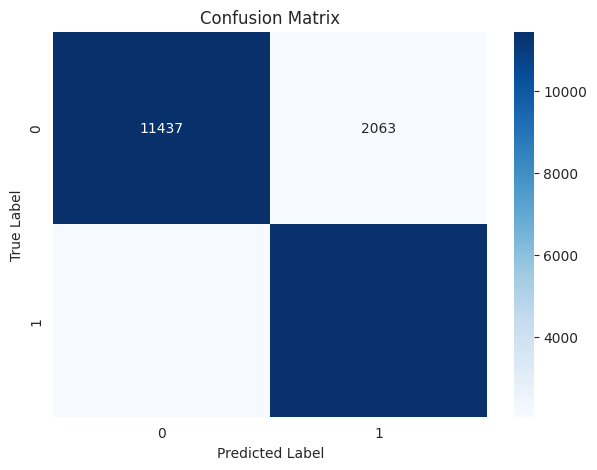

In [76]:
cm = confusion_matrix(y_validation, y_pred_classes)

# Plotando a matriz de confusão
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

In [70]:
print(cm)

[[11437  2063]
 [ 2110 11390]]


## 5.4 Predict on Test

We have over 300.000 samples on test. I choose to work with 30.000(10%) because it's enough to see if the model can generalize.

In [77]:
df_test = pd.read_csv(PATH + 'test.csv')

### 5.4.1 Clean Test

In [78]:
df_test.columns = ['sentiment','title','text']
df_test, _ = train_test_split(df_test, test_size=0.9, stratify=df_test['sentiment'], random_state=42)
df_test.head()

,sentiment,title,text
141420,2,"Excellent, and does what it's supposed to do",Although I would have appreciated a little mor...
244397,1,Meh,"Honestly, in the last...i felt there were 2 so..."
88758,1,Get over it dude,This is not a very good cd. Artimus needs to m...
191403,2,Polar Express Book and DVD,I would reccomend this book and video to every...
264369,1,Poor product description by amazon.com,"When I purchased this gage, the product descri..."


In [79]:
df_test = df_test.drop(['title'], axis=1)
df_test['text'] = df_test['text'].apply(process_text)

sequences_test = tokenizer.texts_to_sequences(df_test['text'])

X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [80]:
df_test['sentiment'] = df_test['sentiment'].apply(lambda x: 'Negative' if x == 1 else 'Positive')
df_test['sentiment'] = df_test['sentiment'].map(sentiment_map)
y_test = df_test['sentiment'].copy()

In [81]:
y_pred_test = model.predict(X_test)
y_pred_classes_test = (y_pred_test > 0.5).astype(int)


1250/1250 [==============================] - 151s 120ms/step


### 5.4.2 Evalute Test

In [83]:
evaluate_metrics(y_test, y_pred_classes_test)

Accuracy: 0.8462
Precision: 0.8492
Recall: 0.8418
F1 Score: 0.8455


Text(0.5, 1.0, 'Confusion Matrix')

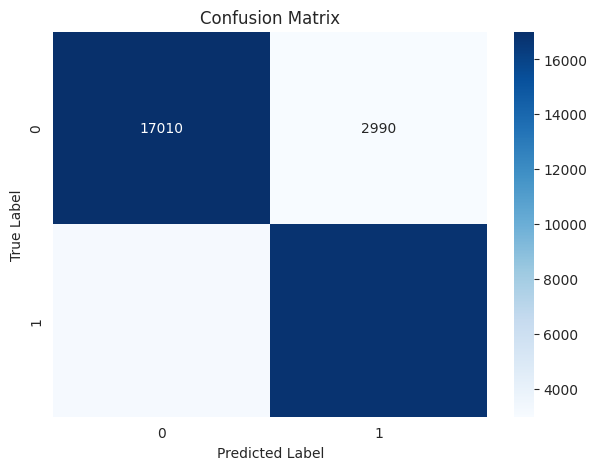

In [84]:
cm = confusion_matrix(y_test, y_pred_classes_test)

# Plotando a matriz de confusão
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

In [105]:
def predict_manual_text(text):
    text = process_text(text)
    
    # Converta o texto processado em uma lista
    sequence_text = tokenizer.texts_to_sequences([text])
    
    # Especifique o maxlen para pad_sequences
    X_text = pad_sequences(sequence_text, maxlen=MAX_SEQUENCE_LENGTH)

    y_pred = model.predict(X_text)
    y_class = (y_pred > 0.5).astype(int)

    # Use uma abordagem baseada em compreensão de lista para mapear os sentimentos
    sentiment = [sentiment_map_reverse[val[0]] for val in y_class]
    
    return sentiment[0]
    

# 6.0 Test on Manual Texts

In [107]:
# Exemplo de uso:
text_sample = "It was an OK book..."
predicted_sentiment = predict_manual_text(text_sample)
print(predicted_sentiment)

1/1 [==============================] - 0s 327ms/step
Negative


# 7.0 Business Performance

## Assumptions
- Amazon Receives an average of 10,000 reviews per day.
- 5% of these reviews are negative, amounting to 500 negative reviews daily.

## Dissatisfaction Cost
- For every negative review that goes unidentified and unaddressed, Amazon could potentially lose that customer permanently.
- It's estimated that the Lifetime Value (LTV) of each Amazon customer is $500. This value represents the expected profit from a customer over the entirety of their relationship with the company.

## Recall Before and After:
- 
Before: Before implementing the model, let's assume Amaz y identified onl6550% of the negative revie by using the star rating systemws, i.e., a Recall o6550%. This mean17550 negative reviews3550% of 500) are missed daily- .
After: With the model in place, the Recall is 87.30%. As a result, Amazon now identifies 436 negative reviews (87.30% of 500) daily, missing only 64 reviews.